In [11]:
import torch
from PIL import Image
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
import faiss
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

model = AutoModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [14]:
from datasets import load_dataset

ds = load_dataset("jmhessel/newyorker_caption_contest", "explanation")

Generating test split: 100%|██████████| 131/131 [00:00<00:00, 18121.23 examples/s]


In [22]:
print(ds["train"][0]["image_description"])
ds["train"][0]["image"]

Two women are looking out a window. There is snow outside, and there is a snowman with human arms.


PIL.JpegImagePlugin.JpegImageFile

In [25]:
ds['train']

Dataset({
    features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id'],
    num_rows: 2340
})

In [24]:
dataset = ds["train"]
ds_with_embeddings = dataset.map(
    lambda example: {
        "embeddings": model.get_text_features(
            **tokenizer([example["image_description"]], truncation=True, return_tensors="pt").to("mps")
        )[0]
        .detach()
        .cpu()
        .numpy()
    }
)

Map: 100%|██████████| 2340/2340 [01:30<00:00, 25.79 examples/s]


A snowman has branches for arms, not human arms. 


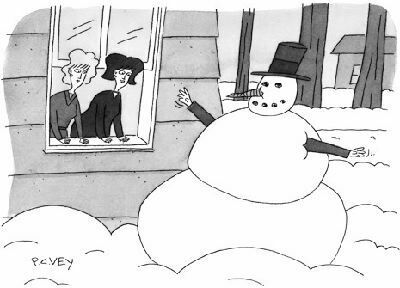

In [42]:
print(ds_with_embeddings['image_uncanny_description'][0], ds_with_embeddings.description)
ds_with_embeddings['image'][0]

In [ ]:
# create FAISS index for text embeddings
ds_with_embeddings.add_faiss_index(column="embeddings")
# create FAISS index for image embeddings
ds_with_embeddings.add_faiss_index(column="image_embeddings")

In [46]:
ds_with_embeddings = ds_with_embeddings.map(
    lambda example: {
        "image_embeddings": model.get_image_features(**processor([example["image"]], return_tensors="pt").to("mps"))[
            0
        ]
        .detach()
        .cpu()
        .numpy()
    }
)

Map: 100%|██████████| 2340/2340 [01:19<00:00, 29.37 examples/s]
